In [269]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, metrics
importlib.reload(data)
from data import DataLoader


# Params
features_dict = {'daily':['gage_Q'],
                'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']}
target_label = 'tss'
time_slice = slice('2008-01-01', None)
split_time =  np.datetime64('2017-01-01')
num_samples = 10000
sequence_length = 5
batch_size = 2
num_epochs = 50
hidden_size = 16
feature_size = len(feature_labels)
output_size = 1

data_dir = Path("../data/Sag")

dataloader = DataLoader(data_dir = data_dir,
                        basins = ['sag_daily_data','sag_daily_data_2'],
                        features_dict = features_dict,
                        target = target_label,
                        time_slice = time_slice,
                        split_time = split_time,
                        batch_size = batch_size, 
                        sequence_length = sequence_length,
                        train = True,
                        discharge_col = 'gage_Q',
                        zero_min_cols = ['gage_Q','tss'])

for d in dataloader:
    break

d['x_dd'].shape

(2, 5, 1)

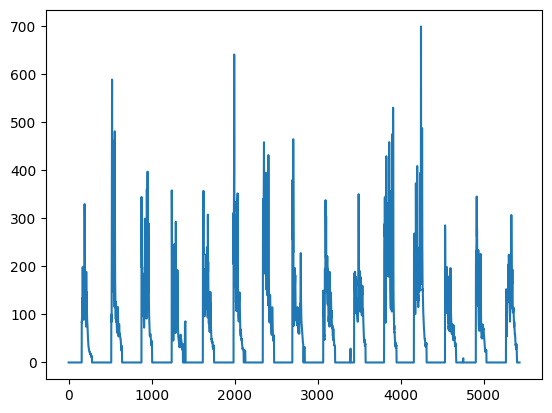

In [96]:
plt.plot(dataloader.xd['sag_daily_data'])

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]])

(0.0, 0.15)

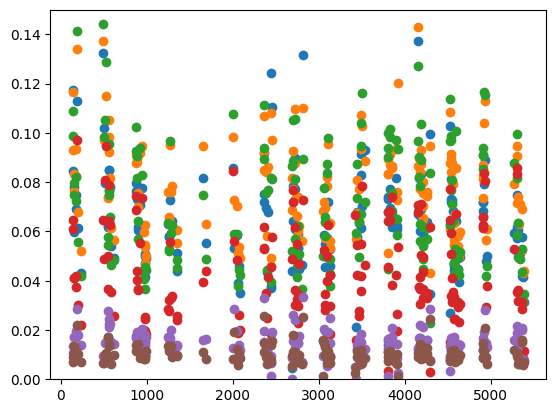

In [97]:
plt.plot(dataloader.xdi['sag_daily_data'],linestyle='None',marker='o')
plt.ylim([0,0.15])

In [247]:
df_dd = pd.DataFrame({
    'A': [1, 2, 2, 3, 4, 5, 6.0],
    'B': [2, 3, 3, 4, 5, 6, 7],
    'C': [3, 4, 4, 5, 6, 7, 8]
})

x_dd = df_dd.values

df_di = pd.DataFrame({
    'A': [np.nan, np.nan, 3, np.nan, 4, np.nan, 6],
    'B': [np.nan, np.nan, 4, np.nan, 5, np.nan, 7],
    'C': [np.nan, np.nan, 5, np.nan, 6, np.nan, 8]
}).dropna()

x_di = df_di.values
x_di_ids = df_di.index.values

# Initialize the result array with zeros
attn_dt = np.zeros(len(x_dd), dtype=float)

# Set leading NaNs in the result array to np.inf
if x_di_ids[0] > 0:
    attn_dt[:x_di_ids[0]] = np.inf

# Loop through the non-NaN indices and fill in the result array
for i in range(len(x_di_ids) - 1):
    start = x_di_ids[i]
    end = x_di_ids[i + 1]
    attn_dt[start + 1:end] = np.arange(1, end - start)

idx = 6
sequence_length = 6

seq_x_dd_ids = np.array(np.arange(idx - sequence_length + 1, idx + 1))
seq_x_dd = x_dd[seq_x_dd_ids]
seq_attn_dt = attn_dt[seq_x_dd_ids]

di_dd_mask = np.isin(x_di_ids,seq_x_dd_ids)
seq_x_di_ids = x_di_ids[di_dd_mask]
seq_x_di  = x_di[di_dd_mask]
seq_x_di_decay_dt = np.diff(seq_x_di_ids, prepend=1)



# seq_x_di_has_obs = ~np.isin(sequence_ids, x_di_ids)
# print((seq_x_di_has_obs))


# print(seq_x_dd_ids)
# print(seq_x_di_ids)
print(f"sequence x_dd: \n{seq_x_dd}")
print(f"sequence x_di: \n{seq_x_di}")
print(f"decay dt: {seq_x_di_decay_dt}")
print(f"attn dt: {seq_attn_dt}")


sequence x_dd: 
[[2. 3. 4.]
 [2. 3. 4.]
 [3. 4. 5.]
 [4. 5. 6.]
 [5. 6. 7.]
 [6. 7. 8.]]
sequence x_di: 
[[3. 4. 5.]
 [4. 5. 6.]
 [6. 7. 8.]]
decay dt: [1 2 2]
attn dt: [inf  0.  1.  0.  1.  0.]


In [65]:
df = pd.DataFrame({
    'A': [1, np.nan, np.nan, 4, np.nan, 6],
    'B': [np.nan, 2, np.nan, np.nan, 5, np.nan],
    'C': [1, np.nan, 3, np.nan, np.nan, np.nan]
})

# Subset of columns to process
columns_to_process = ['A','B','C']

# df.isnull().groupby((df.notnull().cumsum() == 0).cumsum()).sum()

# Fill in missing values for the subset of columns
# df_filled = df.copy()

for col in columns_to_process:
    # Create a mask for NaN values
    nan_mask = df[col].isna()
    
    # Calculate the number of missing measurements since a valid measurement
    df[col+"_dt"] = nan_mask.groupby((nan_mask == False).cumsum()).cumsum()

    # df[col] = df[col].ffill()

    # df[.rename(col+"_dt")]

# # Add the missing_since_last_valid information as new columns
# for col in columns_to_process:
#     df_filled[col + '_dt'] = missing_since_last_valid[col]

print("Filled DataFrame:")
print(df)
print("\ndt DataFrame:")
print(dt)

Filled DataFrame:
     A    B    C  A_dt  B_dt  C_dt
0  1.0  NaN  1.0     0     1     0
1  NaN  2.0  NaN     1     0     1
2  NaN  NaN  3.0     2     1     0
3  4.0  NaN  NaN     0     2     1
4  NaN  5.0  NaN     1     0     2
5  6.0  NaN  NaN     0     1     3

dt DataFrame:


NameError: name 'dt' is not defined